# Check the sensitivity of one basin

In [1]:
# use observed streamflow data to evaluate model outputs
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, sys

def get_modified_KGE(obs,sim):
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge

In [2]:
# load data
infile_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(infile_info)

outpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs_evaluation'
outfile = f'{outpath}/obs_streamflow.nc'
ds_q_obs = xr.load_dataset(outfile)

In [3]:
niter = 200
nparam = 27
params = np.nan * np.zeros([niter+1, nparam])

for i in range(-1, niter):
    if i>=0:
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/paramset_iter0_trial{i}.pkl'
    else:
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/all_default_parameters.pkl' # -1: default paramters
        
    df_param = pd.read_pickle(file)
    va = df_param['Value'].values
    for j in range(nparam):
        params[i+1, j]=np.mean(va[j])

In [4]:
ngrid = len(ds_q_obs.lndgrid)
kge = np.nan * np.zeros([niter+1, ngrid])
for t in range(-1, niter): # -1 is default
    # outfile metric
    outfile_metric = f'{outpath}/metric_iter0_trial{t}.csv'
    df_metric = pd.read_csv(outfile_metric)
    kge[t+1, :] = df_metric['KGEmod'].values

In [5]:
print(kge.shape)
print(params.shape)

(201, 627)
(201, 27)


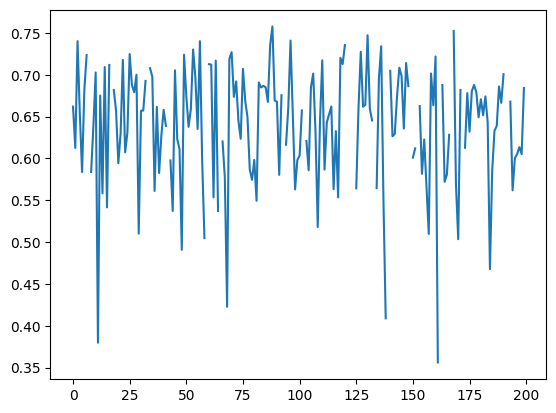

In [6]:
checkbasin = 530
plt.plot(kge[:,checkbasin])

In [7]:
lower = df_param['Lower'].values.copy()[:-3]
upper = df_param['Upper'].values.copy()[:-3]
default = df_param['Default'].values.copy()[:-3]
kgebasin = kge[:, checkbasin].copy()
paramsbasin = params.copy()

indvalid = ~np.isnan(kgebasin)
kgebasin = kgebasin[indvalid]
paramsbasin = paramsbasin[indvalid, :]

print(lower.shape, kgebasin.shape, paramsbasin.shape)

(27,) (180,) (180, 27)


Test MSE: 0.0029930672956275726
[0.63074535 0.63149819 0.63159087 0.62874643 0.62634723 0.62372641
 0.62482081 0.6257308  0.6257308  0.62522577 0.6237467  0.62130434
 0.62127299 0.62194184 0.62239216 0.62239216 0.62253163 0.62256576
 0.62122046 0.62067387]
[0.63144017 0.63144017 0.63144017 0.63144017 0.63144017 0.63136668
 0.63136668 0.63136668 0.63155272 0.63155272 0.63155272 0.63155272
 0.63149616 0.63159087 0.63159087 0.63159087 0.63187081 0.63074481
 0.63074481 0.63074481]
[0.63132853 0.63159087 0.63159087 0.63159087 0.63097189 0.63049141
 0.63049141 0.63049901 0.63055428 0.63059935 0.63060919 0.63123282
 0.63123282 0.63128938 0.63027393 0.63010273 0.63010273 0.62936002
 0.62650729 0.62650729]
[0.62261428 0.62261428 0.62261428 0.62484559 0.62558309 0.63023884
 0.63159087 0.63159087 0.63159087 0.63159087 0.63109973 0.63127897
 0.63134662 0.63089528 0.63089528 0.63089528 0.63089528 0.63089528
 0.6247898  0.62422121]
[0.61944837 0.62020121 0.62214435 0.62214435 0.62232847 0.62566829
 

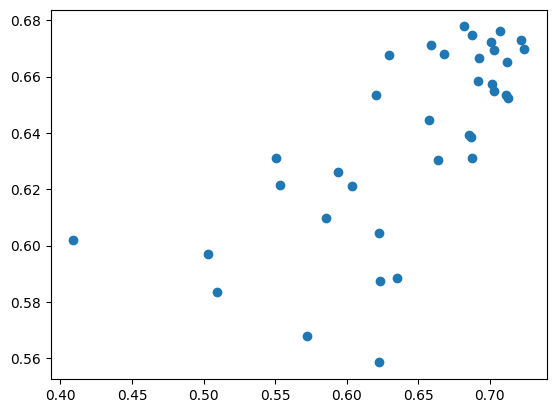

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming lower, upper, kgebasin, and paramsbasin are defined as per your data

# Step 1: Building the emulator
# Split the data into training and testing for model evaluation
X_train, X_test, y_train, y_test = train_test_split(paramsbasin, kgebasin, test_size=0.2, random_state=42)

# Initialize and train the emulator (regression model) using Random Forest
emulator = RandomForestRegressor(n_estimators=100, random_state=42)  # Random Forest model initialization

emulator.fit(X_train, y_train)

# Evaluate the emulator to ensure it's good enough for sensitivity analysis
y_pred = emulator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

plt.scatter(y_test, y_pred)


# step 2: for default parameters, using one-at-a-time to check sensitivity
sensitivity = np.zeros(len(lower))
for i in range(len(lower)):
    parami = np.zeros([len(lower), 20])
    pi = np.linspace(lower[i], upper[i], 20)
    for j in range(20):
        parami[:, j] = default
        parami[i, j] = pi[j]
    
    y_pred = emulator.predict(parami.T)
    print(y_pred)
    sensitivity[i] = 1 - np.nanmean(y_pred)

print(sensitivity)
print(df_param['Parameter'].values[np.argsort(-sensitivity)])

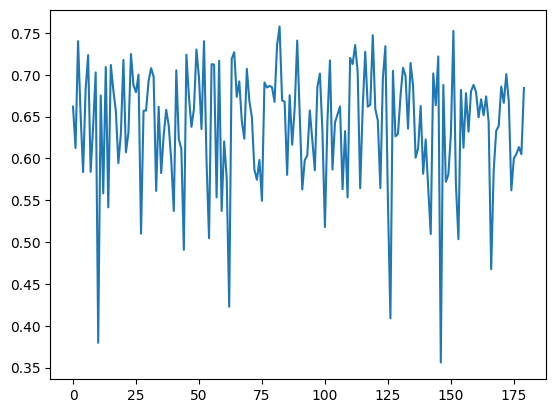

In [9]:
plt.plot(kgebasin)

In [10]:
import numpy as np
from scipy.stats import qmc

n_values=20
n_samples=200


n_parameters = len(lower)
sensitivities = np.zeros(n_parameters)

for i in range(n_parameters):
	values = np.linspace(lower[i], upper[i], n_values)
	sensitivity_values = []
	
	for value in values:
		# Generate LHS for the remaining parameters
		sampler = qmc.LatinHypercube(d=n_parameters-1)
		samples = qmc.scale(sampler.random(n=n_samples), lower[np.arange(len(lower)) != i], upper[np.arange(len(upper)) != i])
		
		for sample in samples:
			# Insert the fixed parameter value into the sampled set
			param_set = np.insert(sample, i, value)
			# Predict kge using the emulator
			predicted_kge = emulator.predict(param_set[np.newaxis,:])
			sensitivity_values.append(predicted_kge)
	
	# Calculate sensitivity for the current parameter
	mean_kge = np.mean(sensitivity_values)
	sensitivities[i] = 1 - mean_kge


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x15466017a940>>
Traceback (most recent call last):
  File "/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
plt.plot(sensitivity_values)

In [ ]:
plt.plot(param_set)
plt.plot(upper)
plt.plot(lower)
plt.yscale('log')

In [ ]:
# ds_simu = xr.open_dataset('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs/iter0_trial73/lnd/hist/level1_iter0_trial73.clm2.h1.2006-10-01-00000.nc')
files = glob.glob('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs/iter0_trial73/lnd/hist/level1_iter0_trial73.clm2.h0.2006-*')
files.sort()
files2 = glob.glob('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs/iter0_trial73/lnd/hist/level1_iter0_trial73.clm2.h0.2007-*')
files2.sort()
files = files + files2
ds_simu = xr.open_mfdataset(files)
ds_simu = ds_simu.isel(lndgrid=checkbasin)



In [ ]:
# ds_simu.H2OSNO.plot()
ds_simu.QRUNOFF.plot()
ds_simu.QFLX_SNOW_DRAIN.plot()

In [ ]:
ds_simu.TBOT.plot()

In [ ]:
# ds_simu.RAIN.plot()
ds_simu.SNOW.plot()
# ds_simu.SNOWDP.plot()

In [ ]:
ds_simu.RAIN.plot()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming lower, upper, kgebasin, and paramsbasin are your data
X_train, X_test, y_train, y_test = train_test_split(paramsbasin, kgebasin, test_size=0.2, random_state=42)

# Initialize and train the emulator (Random Forest model)
emulator = RandomForestRegressor(n_estimators=100, random_state=42)
emulator.fit(X_train, y_train)

import numpy as np

def perform_oat_sensitivity_analysis(emulator, paramsbasin, lower, upper):
    n_parameters = lower.shape[0]
    # baseline_predictions = emulator.predict(paramsbasin)
    # baseline_mean = np.mean(baseline_predictions)
    baseline_mean = 1
    
    sensitivities = []
    for i in range(n_parameters):
        perturbed_params = paramsbasin.copy()
        # Use 20 steps within each parameter's range for perturbation
        step_values = np.linspace(lower[i], upper[i], 20)
        
        parameter_sensitivities = []
        for value in step_values:
            perturbed_params[:, i] = value
            perturbed_predictions = emulator.predict(perturbed_params)
            perturbed_mean = np.mean(perturbed_predictions)
            
            # Sensitivity could be defined in various ways, here we use the mean difference
            sensitivity = np.abs(perturbed_mean - baseline_mean)
            parameter_sensitivities.append(sensitivity)
        
        # Average sensitivity across all perturbations for the current parameter
        sensitivities.append(np.mean(parameter_sensitivities))
    
    return sensitivities

# Perform the sensitivity analysis
sensitivities = perform_oat_sensitivity_analysis(emulator, paramsbasin, lower, upper)

# Sensitivities now holds the average sensitivity of each parameter

In [13]:
paramsbasin.shape

(180, 27)

In [11]:
from pyviscous import pyviscous as vs

In [ ]:
x = paramsbasin
y = kgebasin

sen = []
for xIndex in range(27):
# for xIndex in range(n_xvariables): 
    
    # Calculate sensitivity index.
    sens_indx_first, gmcm_first = vs.viscous(x, y, xIndex, 'first', MSC='AIC')  

    sen.append(sens_indx_first)
    
    print(sens_indx_first)

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.053822
0.053821925617336945
Calculating first-order sensitivity index for variable index 1...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.000737
0.000737207211456871
Calculating first-order sensitivity index for variable index 2...
--- PART A: Data preparation
--- PART B: GMCM inference
	n_component=6, did not converge.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.014989
0.014988668587779589
Calculating first-order sensitivity index for variable index 3...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  7
    Sensitivity index = 

/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: divide by zero encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)
/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: invalid value encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)


/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: divide by zero encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)
/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: invalid value encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)


--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.026647
0.02664716624497353
Calculating first-order sensitivity index for variable index 5...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.007281
0.007281187088382221
Calculating first-order sensitivity index for variable index 6...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.004295
0.004294876621269453
Calculating first-order sensitivity index for variable index 7...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.000771
0.0007713391236115303
Calculating first-order sensitivity index for variable index 8...
--- PART A: Data preparation
--- PART B: GMCM inference
--- 

/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: divide by zero encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)
/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: invalid value encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)


	n_component=8, did not converge.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.015895
0.01589466428022731
Calculating first-order sensitivity index for variable index 10...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  2
    Sensitivity index = 0.127595
0.12759469341872026
Calculating first-order sensitivity index for variable index 11...
--- PART A: Data preparation
--- PART B: GMCM inference


/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: divide by zero encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)
/glade/work/guoqiang/conda-envs/PyVISCOUS/lib/python3.8/site-packages/copulae/mixtures/gmc/marginals.py:95: RuntimeWarning: invalid value encountered in divide
  zi = (np.repeat(x[..., np.newaxis], param.n_clusters, axis=2) - means) / (sigmas * sqrt2)


--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.000787
0.0007865888747143378
Calculating first-order sensitivity index for variable index 12...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.007383
0.007382700881893388
Calculating first-order sensitivity index for variable index 13...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.000902
0.0009018550487331488
Calculating first-order sensitivity index for variable index 14...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  1
    Sensitivity index = 0.043308
0.043308360581273735
Calculating first-order sensitivity index for variable index 15...
--- PART A: Data preparation
--- PART B: GMCM inferenc

In [27]:
sen = np.array(sen)
print(sen)
df_param['Parameter'].values[np.argsort(-sen)]

[0.0488335  0.0006891  0.01511017 0.01816051 0.02673931 0.00744058
 0.00421901 0.00075306 0.00254904 0.01562752 0.08750517 0.00078414
 0.00705981 0.00089929 0.04217416 0.01964231 0.00080354 0.0091675
 0.01648957 0.0073588  0.01030215 0.15077336 0.07359156 0.09056185
 0.00093167 0.00669348 0.00060408]


array(['medlynslope', 'kmax', 'hksat_sf', 'jmaxb0', 'fff',
       'liq_canopy_storage_scalar', 'om_frac_sf',
       'maximum_leaf_wetted_fraction', 'FMAX',
       'upplim_destruct_metamorph', 'zbedrock', 'd_max',
       'precip_repartition_nonglc_all_rain_t', 'accum_factor',
       'interception_fraction', 'zsno', 'n_baseflow', 'taulnir',
       'watsat_sf', 'bsw_sf', 'cv', 'slopebeta', 'n_melt_coef',
       'baseflow_scalar', 'sucsat_sf', 'e_ice', 'leafcn'], dtype=object)

In [30]:
sen = np.array(sen)
print(sen)
df_param['Parameter'].values[np.argsort(-sen)]

[0.05044518 0.00066716 0.01467959 0.12021583 0.02603689 0.00788965
 0.00421346 0.00078666 0.00243181 0.01603427 0.12432344 0.00070912
 0.00728467 0.00092062 0.04285387 0.02142942 0.00079999 0.00879596
 0.01632286 0.00725472 0.09351467 0.15599097 0.07548136 0.07844127
 0.00090396 0.00645184 0.00063204]


array(['medlynslope', 'hksat_sf', 'FMAX',
       'precip_repartition_nonglc_all_rain_t', 'kmax', 'jmaxb0', 'fff',
       'liq_canopy_storage_scalar', 'om_frac_sf',
       'maximum_leaf_wetted_fraction', 'upplim_destruct_metamorph',
       'zbedrock', 'd_max', 'accum_factor', 'interception_fraction',
       'n_baseflow', 'zsno', 'taulnir', 'watsat_sf', 'bsw_sf',
       'slopebeta', 'cv', 'n_melt_coef', 'sucsat_sf', 'baseflow_scalar',
       'e_ice', 'leafcn'], dtype=object)

In [32]:
sen = np.array(sen)
print(sen)
df_param['Parameter'].values[np.argsort(-sen)]

[0.05324573 0.00067517 0.01409456 0.12287089 0.02596422 0.00768258
 0.00401243 0.00072891 0.00245929 0.01552328 0.12732789 0.00074746
 0.00687232 0.00082863 0.04190654 0.02190917 0.00081617 0.0093577
 0.01618369 0.00755508 0.01059946 0.15440533 0.07420598 0.08659186
 0.00088268 0.00697093 0.00063286]


array(['medlynslope', 'hksat_sf', 'FMAX', 'kmax', 'jmaxb0', 'fff',
       'liq_canopy_storage_scalar', 'om_frac_sf',
       'maximum_leaf_wetted_fraction', 'upplim_destruct_metamorph',
       'zbedrock', 'd_max', 'precip_repartition_nonglc_all_rain_t',
       'accum_factor', 'interception_fraction', 'zsno', 'taulnir',
       'n_baseflow', 'watsat_sf', 'bsw_sf', 'cv', 'slopebeta',
       'n_melt_coef', 'baseflow_scalar', 'sucsat_sf', 'e_ice', 'leafcn'],
      dtype=object)

In [34]:
np.sum(sen[np.argsort(-sen)])*0.8

0.652040662858127